# Word Similarity

In this section we compare the GloVe embedding similarity scores on different datasets. We then reduce its dimension and compare the similarity score as a function of the embedding dimension. For this task we use the WS-353 (WordSim) dataset and the RW (rare words) dataset. We use the cosine similarity function:

$cos(w_x, w_y) = \frac{w_x \cdot w_y}{||w_x||_2 ||w_y||_2}$

## 1. Imports

In [ ]:
!pip install --q wget

# general
import os
import time
import warnings

# ML
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error as mse
from sklearn.random_projection import SparseRandomProjection

# visual
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# misc
import wget
import zipfile

warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6) # set default size of plots
sns.set_style('whitegrid')

## 2. Data Preparation

Importing the WS-353 and RW datasets

In [ ]:
if not os.path.exists('wordsim353.zip'):
  wget.download('https://gabrilovich.com/resources/data/wordsim353/wordsim353.zip')

with zipfile.ZipFile('wordsim353.zip', 'r') as zip:
    zip.extract('combined.csv')

In [ ]:
sim_df = pd.read_csv('combined.csv')
sim_df = sim_df.rename(columns={'Word 1': 'word1', 'Word 2': 'word2', 'Human (mean)': 'score'})

sim_df['word1'] = sim_df['word1'].map(str.lower)
sim_df['word2'] = sim_df['word2'].map(str.lower)

print('WS-353 sample:')
sim_df.head()

WS-353 sample:


,word1,word2,score
0,love,sex,6.77
1,tiger,cat,7.35
2,tiger,tiger,10.00
3,book,paper,7.46
4,computer,keyboard,7.62


In [ ]:
if not os.path.exists('rw.zip'):
  wget.download('http://www-nlp.stanford.edu/~lmthang/morphoNLM/rw.zip')

with zipfile.ZipFile('rw.zip', 'r') as zip:
    zip.extract('rw/rw.txt')

In [ ]:
rare_words_df = pd.read_csv('rw/rw.txt', sep='\t', names=['word1', 'word2', 'score'] + list(range(10)))
rare_words_df = rare_words_df[['word1', 'word2', 'score']]

rare_words_df['word1'] = rare_words_df['word1'].map(str.lower)
rare_words_df['word2'] = rare_words_df['word2'].map(str.lower)

print('RW sample:')
rare_words_df.head()

RW sample:


,word1,word2,score
0,squishing,squirt,5.88
1,undated,undatable,5.83
2,circumvents,beat,5.33
3,circumvents,ebb,3.25
4,dispossess,deprive,6.83


In [ ]:
all_pairs_df = pd.concat([sim_df, rare_words_df])

all_words = pd.concat([all_pairs_df['word1'], all_pairs_df['word2']]).unique()
all_words = {word: i for i, word in enumerate(all_words)}
all_words_reverse_index = {i: word for word, i in all_words.items()}

print(f'There are {len(all_pairs_df)} pairs in both datasets and {len(all_words)} unique words.')

There are 2387 pairs in both datasets and 3311 unique words.


Importing the GloVe embedding

In [ ]:
if not os.path.exists('glove.6B.zip'):
  wget.download('https://nlp.stanford.edu/data/glove.6B.zip')

with zipfile.ZipFile('glove.6B.zip', 'r') as zip:
    zip.extract('glove.6B.300d.txt')


NameError: ignored

In [ ]:
# we load to the ram only the vectors of the words in the datasets.
glove_weights = np.zeros((len(all_words), 300))

with open('glove.6B.300d.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
      values = line.split(' ')
      if values[0] in all_words.keys():
        id = all_words[values[0]]
        glove_weights[id] = np.array(values[1:])

indices_without_embeddings = np.where(np.count_nonzero(glove_weights ,axis=1) == 0)[0]

print(f'There are {len(indices_without_embeddings)} words that don\'t have GloVe embedding')

There are 216 words that don't have GloVe embedding


In [ ]:
words_without_embeddings = [all_words_reverse_index[i] for i in indices_without_embeddings]

print('words without embeddings:')
words_without_embeddings

words without embeddings:


['antifeminism',
 'interwove',
 'unisons',
 'unaccessible',
 'opalescence',
 'consubstantial',
 'exceedance',
 'ruralist',
 'conjurors',
 'hypercoaster',
 'anterooms',
 'summonings',
 'hypertexts',
 'autografts',
 'edgeless',
 'extravert',
 'deviationism',
 'disfavoring',
 'companionships',
 'postboxes',
 'transmigrating',
 'interlinks',
 'amazings',
 'monsignori',
 'macrocosmic',
 'instructorship',
 'cosigns',
 'subserve',
 'religionist',
 'totalism',
 'disjoined',
 'protraction',
 'leagued',
 'flavourful',
 'initialise',
 'ulcerate',
 'bestowals',
 'synthetical',
 'vaporise',
 'preposed',
 'nonconscious',
 'transvestitism',
 'nonverbally',
 'transmigrated',
 'unicyclist',
 'dissociations',
 'transfigure',
 'scarceness',
 'independences',
 'fulfillments',
 'algebraist',
 'premisses',
 'moderatorship',
 'vegetational',
 'translunar',
 'affectional',
 'secluding',
 'migrational',
 'procreated',
 'restrainer',
 'bootless',
 'traversals',
 'posthole',
 'unilluminated',
 'sublieutenant',
 

In [ ]:
# removing all oov words from the dataset
sim_df_filtered = sim_df[~sim_df['word1'].isin(words_without_embeddings) & ~sim_df['word2'].isin(words_without_embeddings)]

print(f'WS-353 dataset has {len(sim_df)} pairs, after filtering oov we remianed with {len(sim_df_filtered)} pairs.')

WS-353 dataset has 353 pairs, after filtering oov we remianed with 353 pairs.


In [ ]:
rare_words_df_filtered = rare_words_df[~rare_words_df['word1'].isin(words_without_embeddings) & ~rare_words_df['word2'].isin(words_without_embeddings)]

print(f'RW dataset has {len(rare_words_df)} pairs, after filtering oov we remianed with {len(rare_words_df_filtered)} pairs.')

RW dataset has 2034 pairs, after filtering oov we remianed with 1782 pairs.


We see that the pairs we omitted are from the rare words dataset.

## 3. Baseline Experiment

In this section we embed the words with the original GloVe embedding and get the baseline accuracy of each dataset. We also measure the experiment runtime. Since the scoring is from 0 to 10, we normalize the vectors to unit vectors and then multiply them by $\sqrt{10}$.

In [ ]:
def embed_word(word, word_dict=all_words, embedding_matrix=glove_weights):
  return [embedding_matrix[word_dict[word], :]]

def embed_df(df, embedding_func=embed_word):
  df_embedded = df.copy()
  df_embedded['word1'] = df_embedded['word1'].apply(embedding_func)
  df_embedded['word2'] = df_embedded['word2'].apply(embedding_func)

  return df_embedded


ws_embedded = embed_df(sim_df_filtered)
rw_embedded = embed_df(rare_words_df_filtered)

In [ ]:
def similarity_score(df):
  df['similarity_score'] = df.apply(lambda row: 10  * cosine_similarity(row.word1, row.word2)[0, 0], axis=1)
  return df

In [ ]:
ws_runtime = %timeit -o similarity_score(ws_embedded)

141 ms ± 15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
ws_mse = mse(ws_embedded['score'].to_numpy(), ws_embedded['similarity_score'])

print(f'WS-353 mean squared error embedding score is {ws_mse}. Runtime is {ws_runtime.average * 1000 :.2f}ms')

print('scores sample:')
sim_df_filtered['similarity_score'] = ws_embedded['similarity_score']
sim_df_filtered.head()

WS-353 mean squared error embedding score is 9.722025837240846. Runtime is 141.07ms
scores sample:


,word1,word2,score,similarity_score
0,love,sex,6.77,4.288297
1,tiger,cat,7.35,3.128907
2,tiger,tiger,10.00,10.000000
3,book,paper,7.46,4.542161
4,computer,keyboard,7.62,4.414611


In [ ]:
rw_runtime = %timeit -o similarity_score(rw_embedded)

754 ms ± 83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
rw_mse = mse(rw_embedded['score'].to_numpy(), rw_embedded['similarity_score'])

print(f'RW mean squared error embedding score is {rw_mse}. Runtime is {rw_runtime.average * 1000 :.2f}ms')

print('scores sample:')
rare_words_df_filtered['similarity_score'] = rw_embedded['similarity_score']
rare_words_df_filtered.head()

RW mean squared error embedding score is 27.30550593027981. Runtime is 753.58ms
scores sample:


,word1,word2,score,similarity_score
0,squishing,squirt,5.88,2.149289
2,circumvents,beat,5.33,-1.588652
3,circumvents,ebb,3.25,-0.199495
4,dispossess,deprive,6.83,2.808421
6,provincialism,partiality,4.50,2.628339


## 4. JLT Embedding Experiment

In this section we apply the Johnson-Lindenstrauss transformation on the GloVe embedding and compute the cosine similarity of datasets.


JL is a dimensionality reduction method that preserves Euclidean distance by applying random projection.
Given $\epsilon \in (0, 1)$, a set $X \subset R^D $ there exists a linear map $f : R^D → R^K$ such that:

$$ (1 - \epsilon) ||v - u||_2 \le || f(v) - f(u) ||_2 \le (1 + \epsilon) ||v - u||_2$$

for all $u , v \in X$.

We apply the transformation on the embedding and then compute the cosine-similarity of the reduced vectors.

In [ ]:
components = [300, 250, 200, 150, 100, 75, 60, 50, 30]

def run_jl_experiment(components, df, base_runtime, base_mse, plot_options=None, iterations=10):
  runtimes = [base_runtime]
  mses = [base_mse]

  for component in components:
    accumulating_runtime = 0.0
    accumulating_mse = 0.0

    if component == 300:
      continue

    for _ in range(iterations):
      sp = SparseRandomProjection(n_components = component)
      reduced_weights = sp.fit_transform(glove_weights)
      embedding_func = lambda word: embed_word(word, all_words, reduced_weights)

      embedded_df = embed_df(df, embedding_func)

      st = time.process_time()
      embedded_df = similarity_score(embedded_df)
      et = time.process_time()

      df_mse = mse(embedded_df['score'].to_numpy(), embedded_df['similarity_score'])

      accumulating_runtime += (et - st) * 1000
      accumulating_mse += df_mse

      del embedded_df

    runtimes.append(accumulating_runtime / iterations)
    mses.append(accumulating_mse / iterations)


  if plot_options is not None:
    plt.plot(components, mses, 'bo-')
    plt.plot(components, [base_mse] * len(components), 'r--')
    plt.xlabel('Components Number')
    plt.ylabel('MSE (Relative to Human Score)')
    plt.legend(['Exp results', 'Baseline result'])
    plt.title(plot_options['mse_title'])
    plt.show()

    plt.plot(components, runtimes, 'bo-')
    plt.plot(components, [base_runtime] * len(components), 'r--')
    plt.xlabel('Components Number')
    plt.ylabel('Runtime (ms)')
    plt.legend(['Exp results', 'Baseline result'])
    plt.title(plot_options['runtime_title'])
    plt.show()


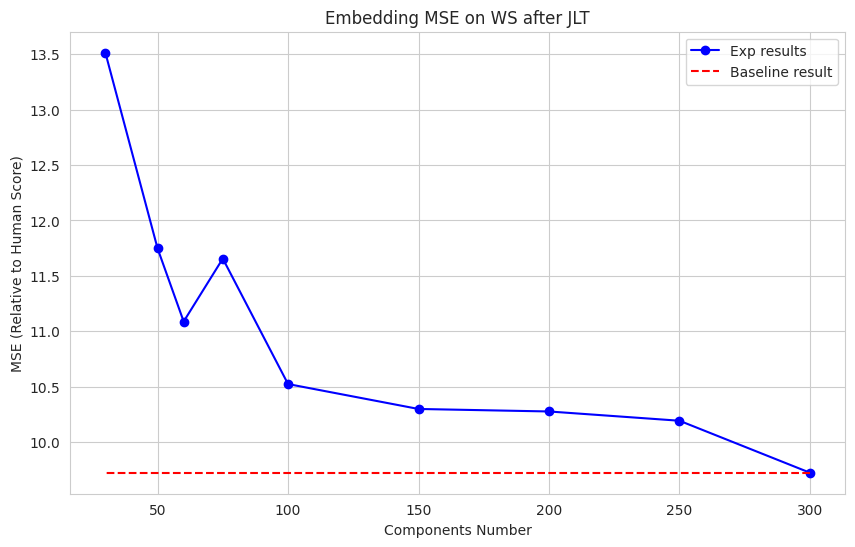

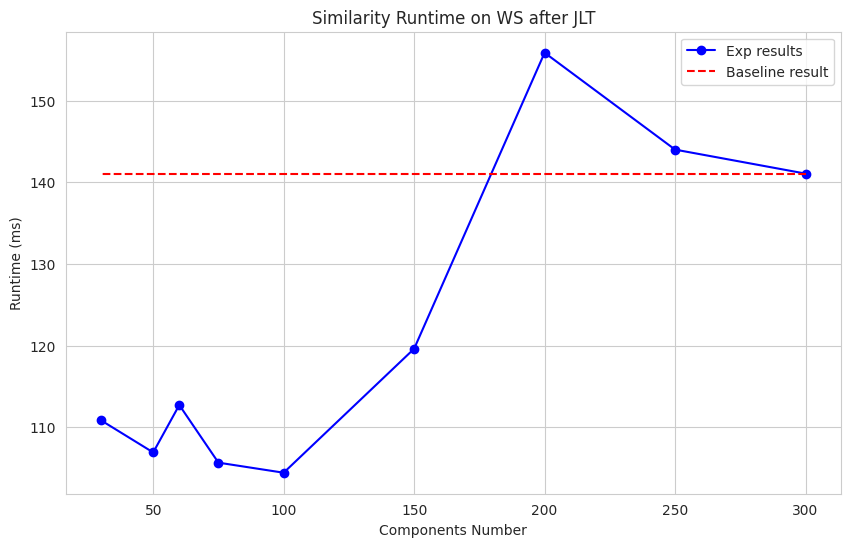

In [ ]:
run_jl_experiment(components, sim_df_filtered, ws_runtime.average * 1000, ws_mse, {'mse_title': 'Embedding MSE on WS after JLT', 'runtime_title': 'Similarity Runtime on WS after JLT'})

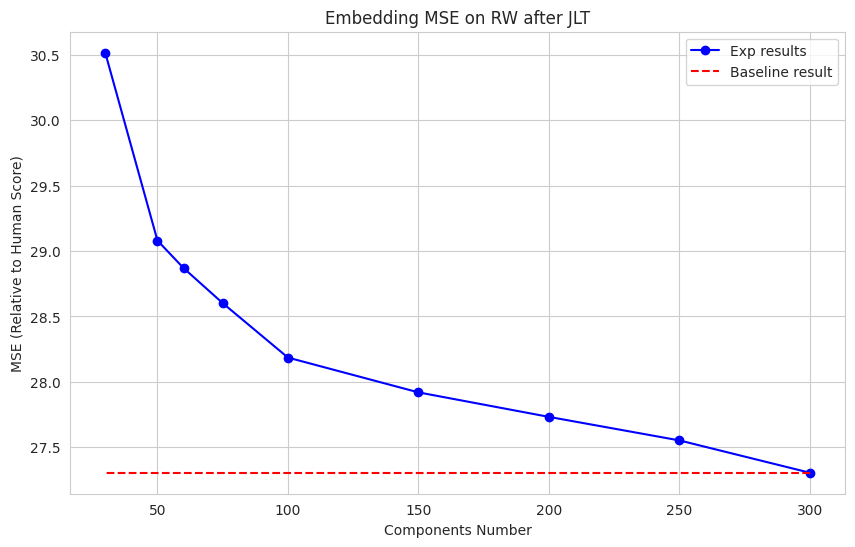

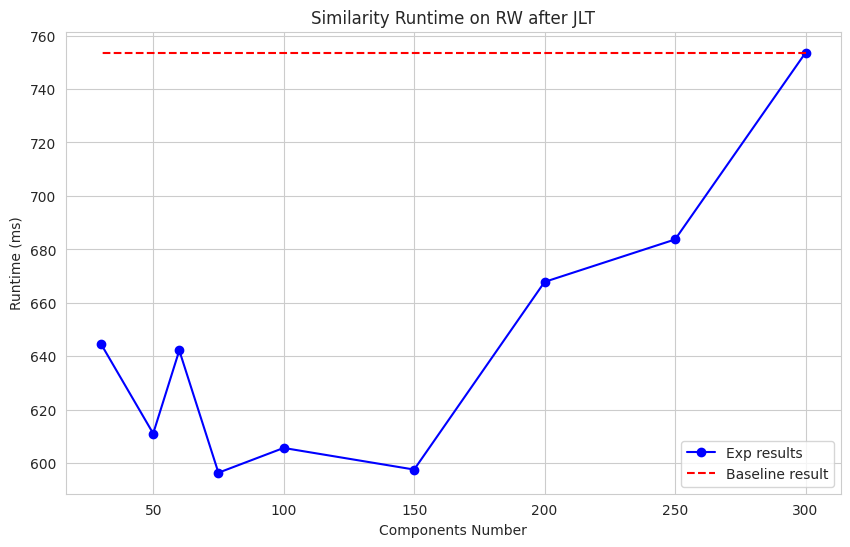

In [ ]:
run_jl_experiment(components, rare_words_df_filtered, rw_runtime.average * 1000, rw_mse, {'mse_title': 'Embedding MSE on RW after JLT', 'runtime_title': 'Similarity Runtime on RW after JLT'})


## 5. CSSRPL Embedding Experiment

In this section we apply the CSSRPL transformation on the GloVe embedding and compute the cosine similarity of datasets.


In the *Improving Sign-Random-Projection via Count Sketch* [[1](https://openreview.net/pdf?id=StLUq88jqx9)] paper the authors propose two ways to improve Sign-Random-Projection (SRP) or SimHash algorithms which provides an unbiased estimate for pairwise cosine similarity of vectors.

<br>

The CSSRP algorithm is based on the sketch proposed in [[2](https://www.cs.princeton.edu/courses/archive/spr04/cos598B/bib/CharikarEstim.pdf)] which works as follows:

let $A \in R^{K \times D}$ be a random linear operator where $\forall a_{ij} \sim 𝒩 \ (0,1)$ and let $a,b \in R^D$.

Now let $\alpha, \beta \in \{0,1\}^K$ such that $\alpha_i = \Bbb{I} _{ Aa_i > 0}$ and $\beta_i =  \Bbb{I}_{ Ab_i > 0}$ (meaning that the projection vectors get one when the product of the vector with the projection matrix row is positive). Now if we take the Hamming distance between $\alpha, \beta$ and multiply it by $\frac{\pi}{K}$ we get the angle between $a,b$:

$X = \frac{\pi}{K} \sum_{i=1}^{K} X^{(i)}$ where $ X^{(i)} =  \Bbb{I}_{ \alpha_i \ne \beta_i}$

$\theta_{(a,b)}=𝔼[X]$

which is equivalent to:

$\theta_{(a,b)}= \frac{\pi}{K} || \alpha - \beta ||_1$


<br>


The authors propose instead of applying the random projection $A$, sketching each input vector with Count Sketch (with $d$ rows and $w$ buckets in each row, altogether $d \cdot w = K$) and then continuing as mentioned before:

$\forall a,b \in R^D$ create Count sketches $\alpha, \beta \in ℤ^K$, then apply function $h( \cdot )$ on each sketch where $h$ takes each component of the input vector and returns 1 if it is positive, else 0. Then we compute:

$\theta_{(a,b)}= \frac{\pi}{K} || h(\alpha) - h(\beta) ||_1$

The paper shows that this is an unbiased estimate of the cosine similarity of any two vectors and furthermore, this result has smaller variance than the SRP.

<br>

In the second part of the paper, the authors suggest another improvement to the original algorithm- instead of using the random operator $A \in R^{K \times D}$ where $\forall a_{ij} \sim 𝒩 \ (0,1)$, they offer using a matrix $A' \in R^{K \times D}$ where each column has $l$ random entries which are $\{\pm1\}$ with probability $\frac{1}{2}$ and the rest of the matrix is $0$. The rest of the algorithm stays the same - projecting the vectors, applying the function $h( \cdot )$ and computing the Hamming distance.

<br>

We use the second technique and apply it on the GloVe embedding: for each pair $a,b$ we compute:
$sim(a,b) = cos(\theta_{(a,b)})= cos(\frac{\pi}{K} || h(\alpha) - h(\beta) ||_1)$

where $\alpha_i = \Bbb{I} _{ A'a_i > 0}$ and $\beta_i =  \Bbb{I}_{ A'b_i > 0}$

In [ ]:
components = [300, 250, 200, 150, 100, 75, 60, 50, 30]

def cssrpl_similarity(df, component):
    df['similarity_score'] = df.apply(lambda row: 10 * np.cos((np.pi / component) * np.linalg.norm(row.word1[0] - row.word2[0], ord=1)), axis=1)
    return df

def run_cssrpl_experiment(components, df, base_runtime, base_mse, plot_options=None, iterations=10):
  runtimes = [[base_runtime], [base_runtime], [base_runtime]]
  mses = [[base_mse], [base_mse], [base_mse]]
  l_values = [2, 3, 4]

  for i, l in enumerate(l_values):
    for component in components:
      accumulating_runtime = 0.0
      accumulating_mse = 0.0

      if component == 300:
        continue

      for _ in range(iterations):
        projection_matrix = np.zeros((component, 300))

        for col in range(component):
          non_zero_indices = np.random.choice(component, l)
          for row in non_zero_indices:
            projection_matrix[row, col] = np.random.randint(2) * 2 - 1


        projection = (glove_weights @ projection_matrix.T)
        reduced_weights = np.where(projection > 0, 1, 0)

        embedding_func = lambda word: embed_word(word, all_words, reduced_weights)
        embedded_df = embed_df(df, embedding_func)

        st = time.process_time()
        embedded_df = cssrpl_similarity(embedded_df, component)
        et = time.process_time()

        df_mse = mse(embedded_df['score'].to_numpy(), embedded_df['similarity_score'])

        accumulating_runtime += (et - st) * 1000
        accumulating_mse += df_mse

        del embedded_df

      runtimes[i].append(accumulating_runtime / iterations)
      mses[i].append(accumulating_mse / iterations)


  if plot_options is not None:
    plt.plot(components, mses[0], 'bo-')
    plt.plot(components, mses[1], 'go-')
    plt.plot(components, mses[2], 'co-')
    plt.plot(components, [base_mse] * len(components), 'r--')
    plt.xlabel('Components Number')
    plt.ylabel('MSE (Relative to Human Score)')
    plt.legend(['Exp results l=2', 'Exp results l=3', 'Exp results l=4', 'Baseline result'])
    plt.title(plot_options['mse_title'])
    plt.show()

    plt.plot(components, runtimes[0], 'bo-')
    plt.plot(components, runtimes[1], 'go-')
    plt.plot(components, runtimes[2], 'co-')
    plt.plot(components, [base_runtime] * len(components), 'r--')
    plt.xlabel('Components Number')
    plt.ylabel('Runtime (ms)')
    plt.legend(['Exp results l=2', 'Exp results l=3', 'Exp results l=4', 'Baseline result'])
    plt.title(plot_options['runtime_title'])
    plt.show()

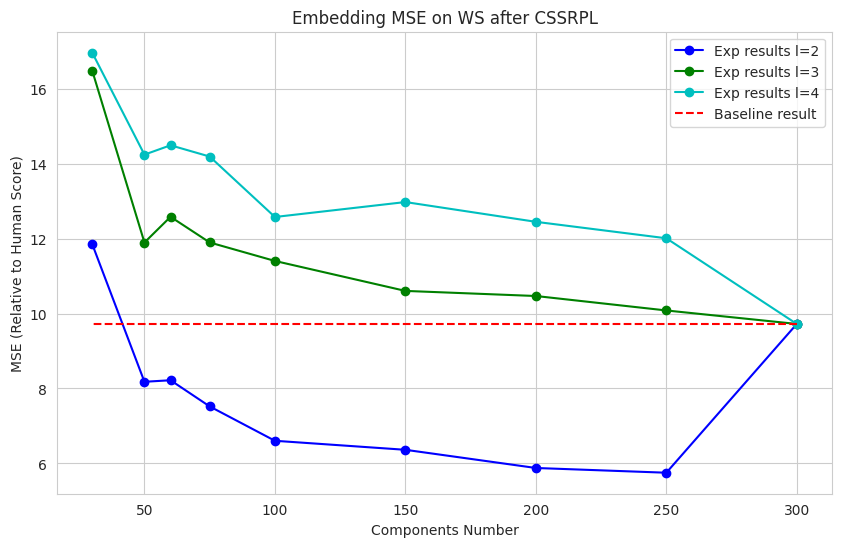

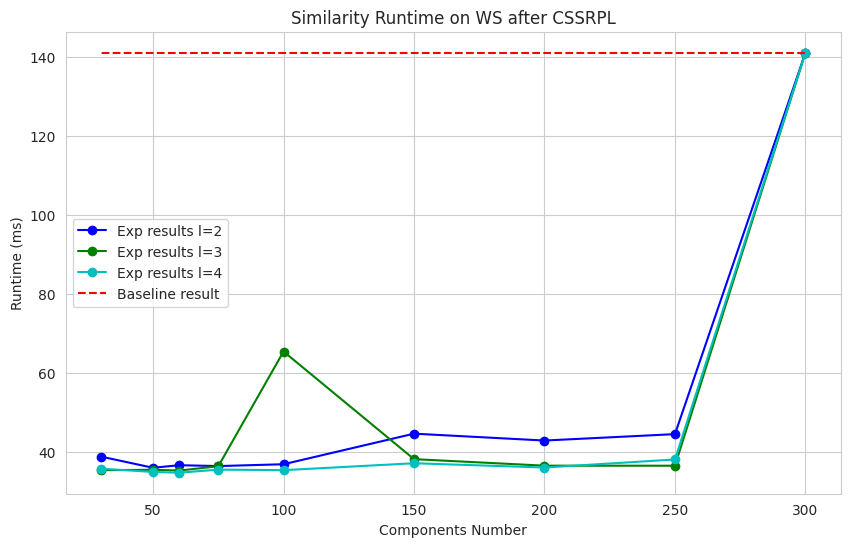

In [ ]:
run_cssrpl_experiment(components, sim_df_filtered, ws_runtime.average * 1000, ws_mse, {'mse_title': 'Embedding MSE on WS after CSSRPL', 'runtime_title': 'Similarity Runtime on WS after CSSRPL'})

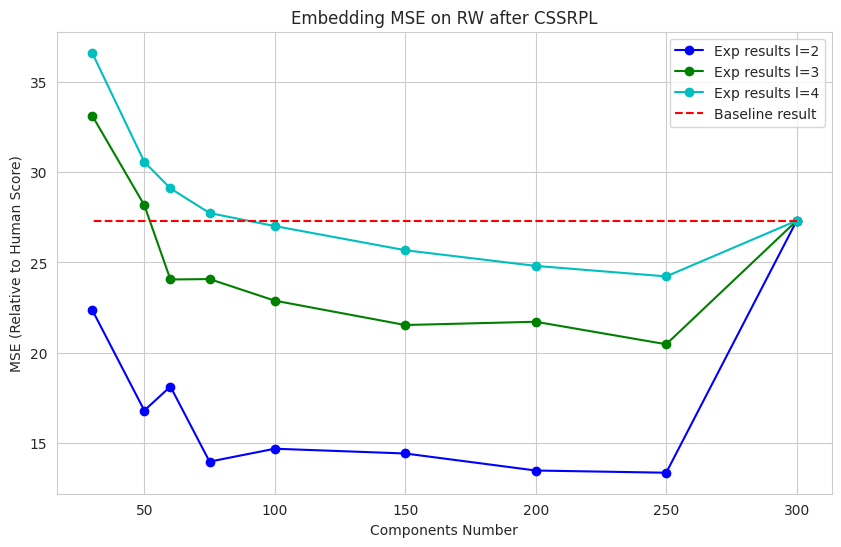

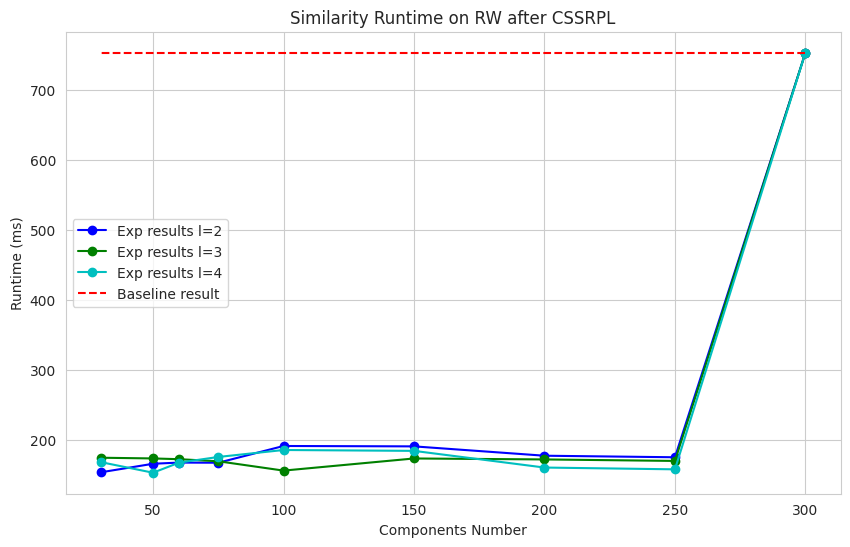

In [ ]:
run_cssrpl_experiment(components, rare_words_df_filtered, rw_runtime.average * 1000, rw_mse, {'mse_title': 'Embedding MSE on RW after CSSRPL', 'runtime_title': ''})

# Refrences

[1] Dubey, Punit Pankaj, et al. "Improving sign-random-projection via count sketch." Uncertainty in Artificial Intelligence. PMLR, 2022.

[2] Moses S Charikar. Similarity estimation techniques from
rounding algorithms. In Proceedings of the thiry-fourth
annual ACM symposium on Theory of computing, pages
380-388, 2002.